## **Boosting Marketing Efficiency: Targeted Bank Campaign by Customer Subscription Behavior**

**Overall Project Objective:** 

Develop a data-driven marketing strategy that maximizes return on investment (ROI) by identifying optimal trade-off between broad customer outreach and precision marketing using predictive modeling.

**Notebook 3 of 3: Feature Importance & Business Impact Analysis

This notebook dives deeper into our final model and derive business insight that fulfills our overall project objective.

### **Setup & Data Load**

Libraries, the final model, and the test data load.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.inspection import PartialDependenceDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [2]:
# load the trained model (random forest) 
file_path = '../models/tuned_rf_mod.joblib'
tuned_rf_mod = joblib.load(file_path)
# load the scaler (for partial dependence plot)
scaler = joblib.load('../models/scaler.joblib')

**-Data Overview-**

Only the test data files ('X_test_scaled', 'y_test') will be used in this notebook. 

In [3]:
# load the test data
X_test_scaled = pd.read_csv('../data/X_test_scaled.csv') # scaled test data
X_test_original = pd.read_csv('../data/X_test_original.csv') # original, unscaled test data
y_test = pd.read_csv('../data/y_test.csv').squeeze() # target test data

print("Test set shape: ", X_test_scaled.shape)

Test set shape:  (905, 37)


### **Feature Importance Analysis**

To understand why our model makes its predictions, we will begin by analyzing its feature importances. This analysis will reveal which customer attributes and campaign variables are the most powerful predictors of whether a client will subcribe. The result will be visualized using a horizontal bar plot to highlight the top 15 most influential predictors. 

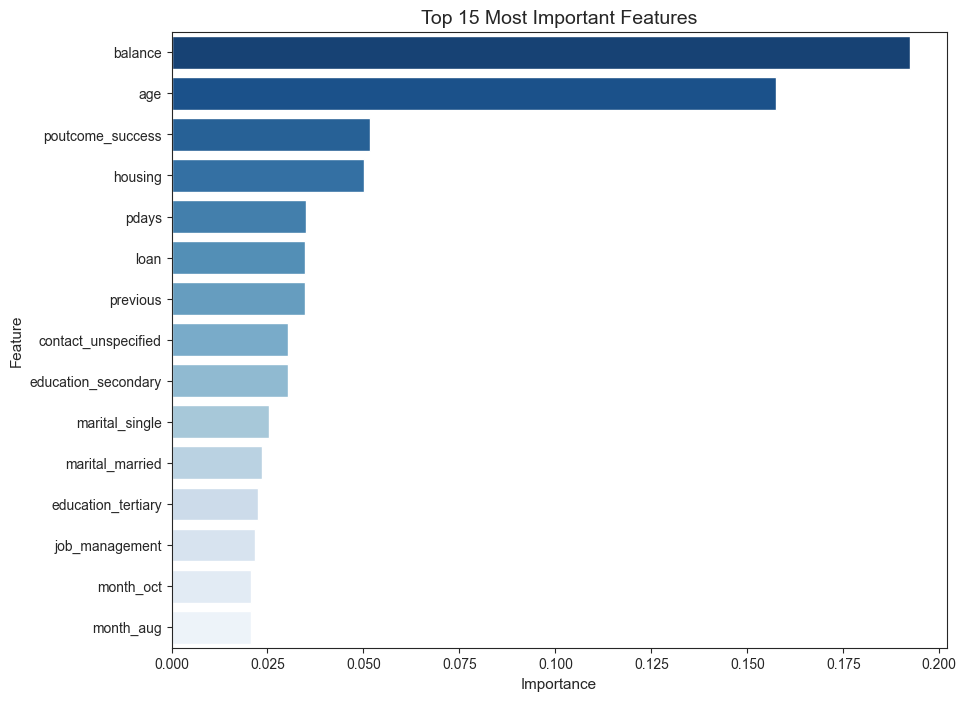

In [4]:
importance = tuned_rf_mod.feature_importances_
feature_importances = pd.Series(importance, index=X_test_scaled.columns)

top_15_features = feature_importances.sort_values(ascending=False).head(15)

sns.set_style('ticks')
plt.figure(figsize=(10,8))
sns.barplot(x=top_15_features.values, 
            y=top_15_features.index,
            hue=top_15_features.index,
            legend=False,
            palette='Blues_r')

plt.title("Top 15 Most Important Features", fontsize=14)
plt.xlabel("Importance", fontsize=11)
plt.ylabel("Feature", fontsize=11)
plt.show()

The feature importance analysis reveals that our model's predictions are driven by four key themes, providing a clear picture of the ideal customer profile. 
1. **Financial Profile:** A client's financial situation is the most dominant factor. 'Balance' is the single most important feature, followed by existing obligations such as 'housing' and 'loan.' This strongly suggests that clients with higher financial capacity and fewer debts are the primary target audience.

2. **Previous Campaign Interactions:** A client's history with the bank is highly predictive. A previous success ('poutcome_success') is the strongest indicator in this group, followed closely by the recency of the last contact ('pdays'). This proves that re-engaging with previously successful or recently contacted clients is a highly effective strategy. 

3. **Client Demographics:** While many demographic features are important, a client's 'age' is by far the most influential, reinforcing the idea that life stage is critical factor.

4. **Campaign Execution:** The analysis also validates our feature engineering, with 'contact_unspecified" ranking as a top-10 predictor. This confirms that the lack of known contact method is a significant piece of information. Seasonal factors like the month of contact also contribute to the model's predictions.

Building on these findings, the next section will examine these key themes in greater detail using partial dependence plots to further refine our business strategy.

**Deeper Dive: The Financial Profile**

Given that financial variables dominate the feature importance list, this section will focus on the single most influential predictor: a client's account 'balance.' By examining how the model's predictions change with different 'balance' levels, we can translate this key insight into a more effective marketing and targeting strategy.

To visualize the effect of account 'balance' on the model's prediction, we will generate a partial dependence plot. The plot is created using the scaled data that the model was trained on, which allows us to accurately see the shape and trend of the relationsihip.

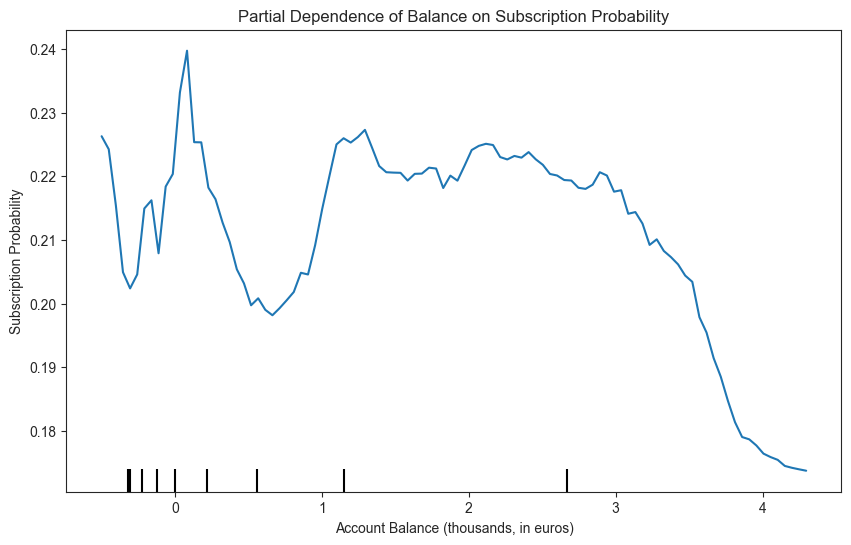

In [5]:
fig, ax = plt.subplots(figsize=(10,6))
pdp_display = PartialDependenceDisplay.from_estimator(
    estimator=tuned_rf_mod,
    X=X_test_scaled,
    features=['balance'],
    ax=ax
)

ax = pdp_display.axes_[0,0]
ax.set(title="Partial Dependence of Balance on Subscription Probability",
       xlabel="Account Balance (thousands, in euros)",
       ylabel="Subscription Probability")
plt.show()

*To make the plot's x-axis easily interpretable in real-world terms, the following lookup table translates the key scaled values back to their original account balances in Euros. This allows us to connect the key points on the plot directly to meaningful business insights.*

In [6]:
print("--- Scaled Value to Balance Lookup Table ---\n")
num_cols = ['age','balance','pdays','previous']
balance_index = num_cols.index('balance')
balance_median = scaler.center_[balance_index]
balance_iqr = scaler.scale_[balance_index]

scaled_values_check = [-1, 0, 1, 2, 3, 4]
for scaled_val in scaled_values_check:
    original_balance = (scaled_val * balance_iqr) + balance_median
    print(f"A scaled value of {scaled_val:2} corresponds to a balance of around € {int(original_balance):8,.2f}")

--- Scaled Value to Balance Lookup Table ---

A scaled value of -1 corresponds to a balance of around €  -939.00
A scaled value of  0 corresponds to a balance of around €   444.00
A scaled value of  1 corresponds to a balance of around € 1,827.00
A scaled value of  2 corresponds to a balance of around € 3,211.00
A scaled value of  3 corresponds to a balance of around € 4,594.00
A scaled value of  4 corresponds to a balance of around € 5,978.00


The partial dependence plot for 'balance' reveals a complex, non-linear relationship with subscription probability, suggesting four distinct customer segments. 

1. **The Financially Stretched:** This group represents the highest peak in subscription probability. Counter-intuitively, these are clients with a negative or a very low positive balance (up to approx. €400). This suggests they may be actively seeking structured savings products to achieve financial stability, making them **highly recpetive audience.** 

2. **The Cautious Saver:** Following the initial peak, subscription probability dips significantly. This segment consists of clients with a balance between roughly €500 and €1,800. They may be more risk-averse, representing either a **lower-priority target or a different kind of marketing opportunity.**

3. **The Mass Affluent:** This group forms the second, broader peak, with a consistently high subscription probability for clients with balances between €1,800 and €3,200. As a stable, high-value segment with disposable income, they are a **prime target for marketing efforts.**

4. **The High Net Worth:** Finally, for clients with balances above approximately €3,200, **subscription probability steadily declines.** This suggests these clients have access to more sophisticated investment options, making a term deposit less appealing.

**Deeper Dive: The Role of Client Demographics**

Client demographics are a significant factor in our model, accounting for 6 of the top 15 most important features. Among these, a client's 'age' is the most influential demographic predictor. This section will focus specifically on the 'age' variable. By examining how it influences the model's predictions, we can derive actionable business insights for more effective customer targeting.

To visualize how 'age' influences model's prediction, we will generate another partial dependence plot.

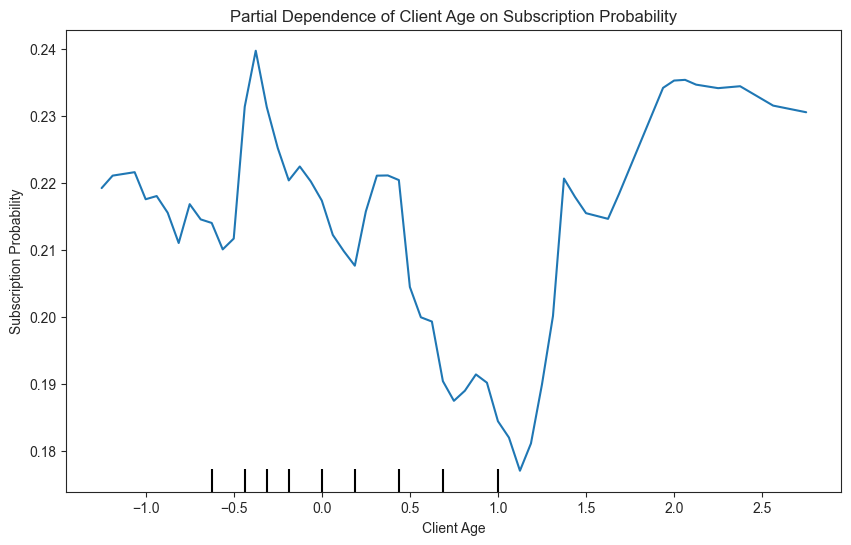

In [7]:
fig, ax = plt.subplots(figsize=(10,6))
pdp_display = PartialDependenceDisplay.from_estimator(
    estimator=tuned_rf_mod,
    X=X_test_scaled,
    features=['age'],
    ax=ax
)

ax = pdp_display.axes_[0,0]
ax.set(title="Partial Dependence of Client Age on Subscription Probability",
       xlabel="Client Age",
       ylabel="Subscription Probability")
plt.show()

*To make the plot's x-axis easily interpretable in real-world terms, the following lookup table translates the key scaled values back to their original ages. This allows us to connect the key points on the plot directly to meaningful business insights.*

In [8]:
print("--- Scaled Value to Age Lookup Table ---\n")
age_index = num_cols.index('age')
age_median = scaler.center_[age_index]
age_iqr = scaler.scale_[age_index]

scaled_values_check = [-1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5]
for scaled_val in scaled_values_check:
    original_age = (scaled_val * age_iqr) + age_median
    print(f"A scaled value of {scaled_val:4.1f} corresponds to an age of around {int(original_age)}")

--- Scaled Value to Age Lookup Table ---

A scaled value of -1.0 corresponds to an age of around 23
A scaled value of -0.5 corresponds to an age of around 31
A scaled value of  0.0 corresponds to an age of around 39
A scaled value of  0.5 corresponds to an age of around 47
A scaled value of  1.0 corresponds to an age of around 55
A scaled value of  1.5 corresponds to an age of around 63
A scaled value of  2.0 corresponds to an age of around 71
A scaled value of  2.5 corresponds to an age of around 79


The partial dependence plot for 'age' reveals a distinct, non-linear U-shaped relationship with subscription probability, highlighting three key life-stage segments:

1. The Younger Professional (Under 35): Subscription probability is highest for clients in their late 20s and early 30s. This suggests that younger clients are a key demographic, likely because they are at a life stage focues on establishing foundational savings habits, making term deposit an attractive first product.

2. The Middel-Aged Squeeze (Age 39 - 55): The probability reaches its lowest point in this range. This is likely due to peak family and financial responsibilities (e.g., raising children, mortgages), leaving less disposable income for this type of savings product.

3. The Pre-Retired & Retired (Over 55): After age 55, subscription probability rises sharply and remains high. This segment is likely shifting its focus to capital preservation and stable, low-risk investments, making term deposits a highly attractive option.

This provides a clear strategic directive: marketing efforts can be most effective when targeting at the youngest and oldest customer segments. 

### **Precision-Recall Trade-Off Analysis**

### **Conclusion & Recommendation**